In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# EDA and Preparation
import pandas as pd
file_path = '/content/drive/MyDrive/ISDS 577 Capstone Project/Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv'
df = pd.read_csv(file_path,low_memory=False)

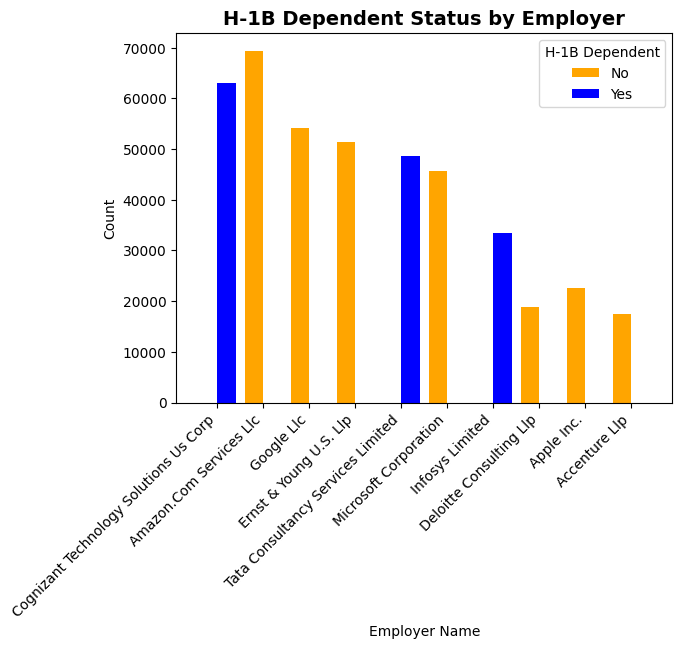

In [4]:
#Miranda
import matplotlib.pyplot as plt
import numpy as np
#select columns wanted for plot
plot_data = df[['EMPLOYER_NAME', 'H_1B_DEPENDENT']].copy()
#make sure all empoyer names are same case
plot_data['EMPLOYER_NAME'] = plot_data['EMPLOYER_NAME'].astype(str).str.strip().str.title()
# standardize yes and no values
plot_data['H_1B_DEPENDENT'] = plot_data['H_1B_DEPENDENT'].astype(str).str.strip().str.upper()
plot_data['H_1B_DEPENDENT'] = plot_data['H_1B_DEPENDENT'].replace({'YES': 'Yes', 'NO': 'No'})
#drop null values from h1_b dependent column
plot_data = plot_data.dropna(subset=['H_1B_DEPENDENT'])
#group/count yes and no values for employer
h1b_dependent_employer_count = plot_data.groupby('EMPLOYER_NAME')['H_1B_DEPENDENT'].value_counts().fillna(0)
#select top employers
top_employers_clean = h1b_dependent_employer_count.unstack().sum(axis=1).nlargest(10).index
top_employers_data_clean = h1b_dependent_employer_count.loc[top_employers_clean].unstack().fillna(0)
top_employers_data_clean.columns = top_employers_data_clean.columns.str.strip().str.title()
#generate plot
x = np.arange(len(top_employers_data_clean.index))
width = 0.4
plt.bar(x - width/2, top_employers_data_clean['No'], width, label='No', color='orange')
plt.bar(x + width/2, top_employers_data_clean['Yes'], width, label='Yes', color='blue')
plt.xlabel('Employer Name')
plt.ylabel('Count')
plt.title('H-1B Dependent Status by Employer', fontsize=14, fontweight='bold')
plt.xticks(x, labels = top_employers_data_clean.index, rotation=45, ha='right', fontsize=10)
plt.legend(title="H-1B Dependent")
plt.show()

In [ ]:
# Miranda
# Question 3: How do machine learning models compare in classifying approved vs. denied H-1B application
# based on employer characteristics and application details?

In [2]:
# EDA and Preparation
import pandas as pd
file_path = '/content/drive/MyDrive/ISDS 577 Capstone Project/Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv'
df = pd.read_csv(file_path,low_memory=False)

In [3]:
# Number of cases per state
df['WORKSITE_STATE'].value_counts().head(10)
# California has the most cases

,count
WORKSITE_STATE,
CA,705974
TX,456475
NY,284518
WA,208162
NJ,188052
IL,161695
MA,137866
GA,131697
NC,128043


In [4]:
df['CASE_STATUS'].value_counts(normalize=True)
# There is a strong imbalance in the dataset. 92% of cases are certified and only 0.6% are denied
# Adress this in model building using SMOTE

,proportion
CASE_STATUS,
Certified,0.923588
Certified - Withdrawn,0.052254
Withdrawn,0.018049
Denied,0.006109


In [5]:
# Data Cleaning
# Standardize column names: strip space, lowercase, useunderscore instead of space
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Classification: Filter for only certified and denied cases
df['case_status'] = df['case_status'].astype(str).str.strip().str.upper()
df = df[df['case_status'].isin(['CERTIFIED', 'DENIED'])]

In [6]:
# Encoding
#Using a smaller sample to build model, unable to run full dataset without RAM issues
df_sample = df.sample(n=100000, random_state=42).copy()

df_sample['h_1b_dependent'] = df_sample['h_1b_dependent'].map({'YES': 1, 'NO': 0})
df_sample['willful_violator'] = df_sample['willful_violator'].map({'YES': 1, 'NO': 0})
df_sample['case_status'] = df_sample['case_status'].astype(str).str.strip().str.upper()
df_sample = df_sample[df_sample['case_status'].isin(['CERTIFIED', 'DENIED'])]
df_sample['case_status_binary'] = df_sample['case_status'].map({'CERTIFIED': 0, 'DENIED': 1})
df_sample['full_time_position'] = df_sample['full_time_position'].map({'Y': 1, 'N': 0})

# Create processing time variable to include as a predictor
df_sample['received_date'] = pd.to_datetime(df_sample['received_date'], errors='coerce')
df_sample['decision_date'] = pd.to_datetime(df_sample['decision_date'], errors='coerce')

df_sample['processing_time'] = (df_sample['decision_date'] - df_sample['received_date']).dt.days

# Limit to top 10 states and industries
df_sample['worksite_state'] = df_sample['worksite_state'].astype(str).str.strip().str.upper()
top_states = df_sample['worksite_state'].value_counts().nlargest(10).index
df_sample['worksite_state_clean'] = df_sample['worksite_state'].where(df_sample['worksite_state'].isin(top_states), other='OTHER')

df_sample['naics_code'] = df_sample['naics_code'].astype(str).str.strip()
top_naics = df_sample['naics_code'].value_counts().nlargest(10).index
df_sample['naics_code_clean'] = df_sample['naics_code'].where(df_sample['naics_code'].isin(top_naics), other='OTHER')

# Dummy variables for categorical variables
df_sample = pd.get_dummies(df_sample, columns=['worksite_state_clean', 'naics_code_clean'], drop_first=True)

# Drop unused/original colums
df_sample = df_sample.drop(columns=[
    'case_status', 'employer_name', 'received_date', 'decision_date',
    'worksite_state', 'naics_code' ])

In [7]:
# Define target variable and predictor variables
y = df_sample['case_status_binary']

predictor_cols = [
    'h_1b_dependent',
    'willful_violator',
    'full_time_position',
    'total_worker_positions',
    'worksite_workers',
    'prevailing_wage',
    'processing_time'
]

dummy_cols = [col for col in df_sample.columns if col.startswith('worksite_state_clean_') or col.startswith('naics_code_clean_')]


In [8]:
# Slit into training and testing data 80/20
df_sample['h_1b_dependent'] = df_sample['h_1b_dependent'].fillna(0).astype(int)
df_sample['willful_violator'] = df_sample['willful_violator'].fillna(0).astype(int)
X = df_sample[predictor_cols + dummy_cols]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# Use SMOTE method to address case status imbalance
from sklearn.impute import SimpleImputer
import numpy as np
imputer = SimpleImputer(strategy='median')

X_train_array = imputer.fit_transform(X_train)

cols_not_dropped = X_train.columns[~np.isnan(X_train).all(axis=0)]

X_train = pd.DataFrame(X_train_array, columns=cols_not_dropped)

X_test_array = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_array, columns=cols_not_dropped)

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Train regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=5000)

In [12]:
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.7).astype(int)

In [13]:
# Display results
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[19680   201]
 [    5   114]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19881
           1       0.36      0.96      0.53       119

    accuracy                           0.99     20000
   macro avg       0.68      0.97      0.76     20000
weighted avg       1.00      0.99      0.99     20000



In [14]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

#use same SMOTE data from logistic regression model
dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [15]:
y_pred_dt = dt_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[19848    33]
 [   32    87]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19881
           1       0.72      0.73      0.73       119

    accuracy                           1.00     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       1.00      1.00      1.00     20000



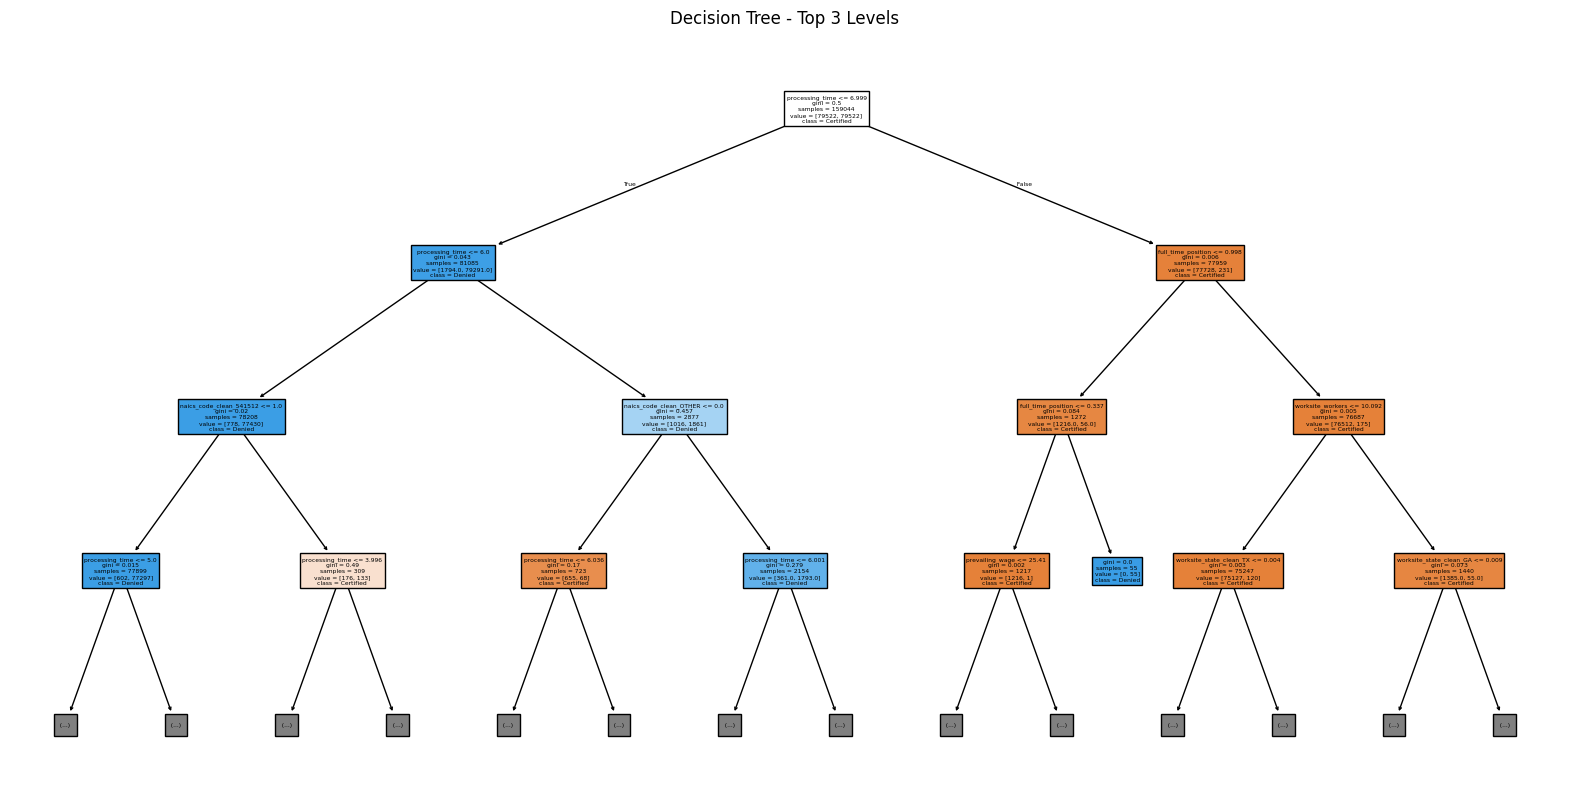

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Certified', 'Denied'], filled=True, max_depth=3)
plt.title("Decision Tree - Top 3 Levels")
plt.show()

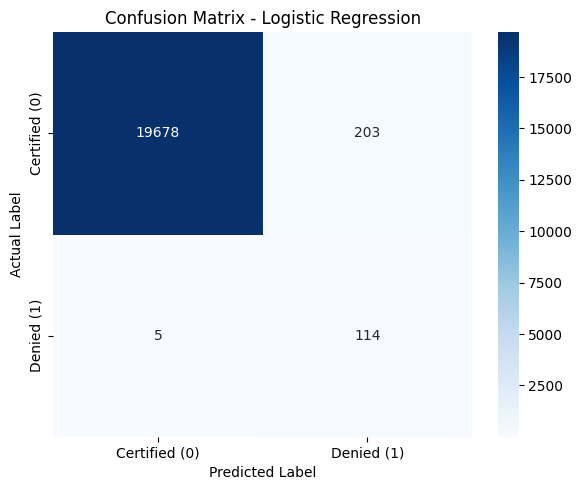

In [18]:
#confusion matrix for logistic regression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = np.array([
    [19678, 203],  # Certified cases
    [5, 114]       # Denied cases
])

labels = ['Certified (0)', 'Denied (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
